# Problem Statement
### According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths (annual mortality rate of 5.5 million).
### Every year, more than 15 million people worldwide have a stroke, and in every 4 minutes, someone dies due to stroke.
### Stroke is preventable in around 80% of cases. However, for prevention we need to find patients at risk i.e. patients with high probability of stroke.
### Here we use machine learning to build a predictive model that predicts the probability of a patient getting stroke based on features like gender, age, various diseases, and smoking status.

# I thought of sharing some domain related resources for the assignment as below. Stroke is a very major disease that has a long run physical and mental impact on the patient and often requires immediate life-saving support and operative treatment methods with a long run rehabilitation. It is a life-threatening disease if not treated on time. Stroke occurs when the blood vessels passing blood from the heart to the brain get damaged either due to plaque (Ischemic) or a rupture (hemorrhage). This is a life threatening disease and often paralyses certain body parts for a long time after initial life saving measures.
### https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113 -- Mayo clinic article for starters
### https://www.webmd.com/stroke/guide/types-stroke -- explains types of stroke, I opine that Ischemic and Hemorrhagic Stroke are the most common types
### https://www.cdc.gov/stroke/signs-symptoms/?CDC_AAref_Val=https://www.cdc.gov/stroke/signs_symptoms.htm
### https://www.nhlbi.nih.gov/health/stroke/causes -- explains the major causes of stroke, could be of importance for the assignment
### https://www.stroke.org/en/about-stroke -- good information from American Stroke Association



In [ ]:
# Standard Libraries
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# Statistical Tests
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Selection
from sklearn.feature_selection import mutual_info_classif, RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix, f1_score, 
    precision_score, precision_recall_curve, recall_score, roc_auc_score, roc_curve
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
import shap

# Summary Tools
from summarytools import dfSummary

# Ignore Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Loading an Basis statistical EDA

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(df.info())
print("++++++"*10)
print(df.describe())
print("++++++"*10)
cat_cols = df.select_dtypes(include=['bool', 'object']).columns.tolist()
for col in cat_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

In [ ]:
df.columns

In [ ]:
dfSummary(df)

## Attribute Information
### 1) id: unique identifier
### 2) gender: "Male", "Female" or "Other"
### 3) age: age of the patient
### 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
### 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
### 6) ever_married: "No" or "Yes"
### 7) work_type: "children", "Govt_jov", "Never worked", "Private" or "Self-employed"
### 8) Residence_type: "Rural" or "Urban"
### 9) avg_glucose_level: average glucose level in blood
### 10) bmi: body mass index
### 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
### 12) stroke: 1 if the patient had a stroke or 0 if not
## *Note: "Unknown" in smoking_status means that the information is unavailable for this patient


# **UNI-VARIATE ANALYSIS**

In [ ]:
def visualize_categorical_data_plotly(df, categorical_cols):
    """
    Generates interactive bar charts for categorical columns using Plotly Express.

    Parameters:
    df (pd.DataFrame): The input dataset.
    categorical_cols (list): List of categorical column names.
    """
    for col in categorical_cols:
        category_counts = df[col].value_counts().reset_index()
        category_counts.columns = [col, 'count']  # Rename columns properly
        
        fig = px.bar(category_counts, x=col, y='count', 
                     title=f'Distribution of {col}', 
                     labels={col: col, 'count': 'Count'}, 
                     color=col, text='count')
        fig.show()


def visualize_numerical_data_plotly(df, numeric_cols):
    """
    Generates interactive histograms with KDE and box plots for numerical columns using Plotly.

    Parameters:
    df (pd.DataFrame): The input dataset.
    numeric_cols (list): List of numerical column names.
    """
    
    # Histograms with KDE
    for col in numeric_cols:
        fig = go.Figure()

        # Histogram
        fig.add_trace(go.Histogram(
            x=df[col], 
            nbinsx=30, 
            histnorm='probability density', 
            name="Histogram", 
            opacity=0.6, 
            marker=dict(color='blue')
        ))

        # KDE Curve (Using Gaussian KDE from SciPy)
        kde = gaussian_kde(df[col].dropna())  # Drop NaNs before estimating density
        x_range = np.linspace(df[col].min(), df[col].max(), 1000)
        kde_values = kde(x_range)

        fig.add_trace(go.Scatter(
            x=x_range, 
            y=kde_values, 
            mode='lines', 
            name="KDE", 
            line=dict(color='red', width=2)
        ))

        # Figure Layout
        fig.update_layout(
            title=f'Distribution of {col} with KDE',
            xaxis_title=col,
            yaxis_title="Density",
            barmode="overlay",
            showlegend=True
        )
        fig.show()

In [ ]:
def visualize_box_plots_plotly(df, numeric_cols):
    # Box plots for numerical variables (univariate analysis)
    for num_col in numeric_cols:
        fig = px.box(df.dropna(subset=[num_col]), y=num_col, title=f'Box Plot of {num_col}')
        fig.show()
def plot_violin_plots(df, numeric_cols):
    """
    Plots violin plots for each numerical variable in the dataset.

    Parameters:
    df (pd.DataFrame): The dataset containing numeric columns.
    numeric_cols (list): List of numerical column names.

    Returns:
    None (Displays violin plots for each numeric variable).
    """
    for num_col in numeric_cols:
        fig = px.violin(df, y=num_col, box=True, points="all",
                        title=f'Violin Plot of {num_col}')
        fig.show()

In [ ]:
# Define first two categorical columns
categorical_cols = ['gender', 'ever_married']
# Call the function 
visualize_categorical_data_plotly(df, categorical_cols)

# Interpretations for the categorical variables based on univariate analysis:

# **Interpretation of Categorical Data Visualization**

| **Feature**       | **Category** | **Count** | **Observations** |
|------------------|------------|---------|----------------|
| **Gender**       | Female     | 2994    | Majority of the dataset consists of female participants. |
|                  | Male       | 2115    | Male participants are fewer than females but still form a significant proportion. |
|                  | Other      | 1       | Only one participant is categorized as "Other". |
| **Ever Married** | Yes        | 3353    | A large proportion of individuals in the dataset have been married. |
|                  | No         | 1757    | Fewer individuals in the dataset have never been married. |

# **Key Insights:**
##  The dataset has a significantly higher number of females compared to males.
##  The "Other" gender category is extremely underrepresented, with only one individual.
##  Most individuals in the dataset have been married at some point.

In [ ]:
# Define next two categorical columns
categorical_cols = ['work_type', 'Residence_type']
# Call the function 
visualize_categorical_data_plotly(df, categorical_cols)

# Interpretation of Categorical Data Visualization

| **Feature**         | **Category**       | **Count** | **Observations** |
|--------------------|------------------|---------|----------------|
| **Work Type**     | Private          | 2925    | Majority of individuals work in the private sector. |
|                  | Self-employed     | 819     | A moderate proportion of individuals are self-employed. |
|                  | Children          | 687     | Children category represents a notable portion, likely indicating non-working dependents. |
|                  | Govt_job          | 657     | A smaller number of individuals are employed in government jobs. |
|                  | Never_worked      | 22      | Very few individuals have never worked. |
| **Residence Type** | Urban            | 2596    | The dataset has a fairly even distribution between urban and rural residences. |
|                  | Rural             | 2514    | Rural residents form almost half of the dataset. |

**Key Insights:**
- Most individuals in the dataset are employed in the private sector.
- A significant portion of the dataset includes children who are not part of the workforce.
- The dataset has a balanced distribution between urban and rural residents.


In [ ]:
# Define next two categorical columns
categorical_cols = ['smoking_status', 'hypertension']
# Call the function 
visualize_categorical_data_plotly(df, categorical_cols)

# Interpretation of Categorical Data Visualization

| **Feature**          | **Category**         | **Count** | **Observations** |
|---------------------|--------------------|---------|----------------|
| **Smoking Status**  | Never smoked       | 1892    | Majority of individuals have never smoked. |
|                    | Unknown            | 1544    | A significant portion of the dataset has unknown smoking status, which may require handling. |
|                    | Formerly smoked    | 885     | A smaller proportion of individuals were former smokers. |
|                    | Smokes             | 789     | The smallest group consists of current smokers. |
| **Hypertension**    | No (0)             | 4612    | Most individuals in the dataset do not have hypertension. |
|                    | Yes (1)            | 498     | A much smaller proportion of individuals have hypertension. |

**Key Insights:**
- The dataset has a significant portion of individuals with unknown smoking status, which might need imputation or separate category handling.
- The majority of individuals have never smoked, while the number of current and former smokers is much lower.
- Hypertension is an imbalanced feature, with a large majority of individuals not having the condition.

In [ ]:
# # Define next two categorical columns
categorical_cols = ['heart_disease', 'stroke']
# Call the function 
visualize_categorical_data_plotly(df, categorical_cols)

## Interpretation of Categorical Data Visualization

| **Feature**       | **Category** | **Count** | **Observations** |
|------------------|------------|---------|----------------|
| **Heart Disease** | No (0)    | 4834    | Majority of individuals do not have heart disease. |
|                  | Yes (1)   | 276     | A small proportion of individuals have heart disease. |
| **Stroke**       | No (0)    | 4861    | The dataset is highly imbalanced, with most individuals not having experienced a stroke. |
|                  | Yes (1)   | 249     | Only a small fraction of the dataset has had a stroke. |

**Key Insights:**
- Heart disease is relatively rare in the dataset, affecting only a small portion of individuals.
- The dataset is highly imbalanced for stroke prediction, with a significantly lower number of stroke cases (only 249 instances).
- This class imbalance may require resampling techniques such as SMOTE or weighted loss functions to improve model performance.

| **Feature**          | **Category**       | **Count** | **Observations** |
|----------------------|-------------------|---------|----------------|
| **Gender**          | Female            | 2994    | Majority of the dataset consists of female participants. |
|                    | Male              | 2115    | Male participants are fewer than females but still form a significant proportion. |
|                    | Other             | 1       | Only one participant is categorized as "Other". |
| **Ever Married**    | Yes               | 3353    | A large proportion of individuals in the dataset have been married. |
|                    | No                | 1757    | Fewer individuals in the dataset have never been married. |
| **Work Type**      | Private           | 2925    | Majority of individuals work in the private sector. |
|                    | Self-employed     | 819     | A moderate proportion of individuals are self-employed. |
|                    | Children          | 687     | Children category represents a notable portion, likely indicating non-working dependents. |
|                    | Govt_job          | 657     | A smaller number of individuals are employed in government jobs. |
|                    | Never_worked      | 22      | Very few individuals have never worked. |
| **Residence Type**  | Urban             | 2596    | The dataset has a fairly even distribution between urban and rural residences. | 
|                    | Rural             | 2514    | Rural residents form almost half of the dataset. |
| **Smoking Status**  | Never smoked      | 1892    | Majority of individuals have never smoked. |
|                    | Unknown           | 1544    | A significant portion of the dataset has unknown smoking status, which may require handling. |
|                    | Formerly smoked   | 885     | A smaller proportion of individuals were former smokers. |
|                    | Smokes            | 789     | The smallest group consists of current smokers. |
| **Hypertension**    | No (0)            | 4612    | Most individuals in the dataset do not have hypertension. |
|                    | Yes (1)           | 498     | A much smaller proportion of individuals have hypertension. |
| **Heart Disease**   | No (0)            | 4834    | Majority of individuals do not have heart disease. |
|                    | Yes (1)           | 276     | A small proportion of individuals have heart disease. |
| **Stroke**         | No (0)            | 4861    | The dataset is highly imbalanced, with most individuals not having experienced a stroke. |
|                    | Yes (1)           | 249     | Only a small fraction of the dataset has had a stroke. |


In [ ]:
# Define numeric columns
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
# Call the function 
visualize_numerical_data_plotly(df, numeric_cols)

# Interpretation Of Histograms For Numeric Columns

| **Feature**             | **Observations** |
|------------------------|----------------|
| **Age**               | The distribution of age appears fairly uniform, with a slight concentration in the middle-aged range. The KDE curve suggests that there is no extreme skewness, but a slight concentration in the middle range. |
| **Avg Glucose Level**  | The distribution of average glucose levels is right-skewed, indicating that most individuals have lower glucose levels, but there are some individuals with significantly higher values. The KDE curve confirms this skewness. |
| **BMI**               | The BMI distribution is approximately normal but slightly right-skewed. Most individuals have BMI values concentrated around the 20-35 range, with fewer cases at the extreme ends. |

**Key Insights:**
- Age distribution is fairly uniform, meaning the dataset covers individuals across different age groups.
- Average glucose level has a strong right skew, which might require transformation (e.g., log transformation) if modeling is affected.
- BMI is roughly normal but has some right skew, indicating the presence of individuals with very high BMI.


In [ ]:
visualize_box_plots_plotly(df, numeric_cols)

# Interpretation of Box Plots for Numeric Columns

### **Interpretation of Skewness, Outliers, and Treatment**

| Feature | Interpretation (Skewness, Outliers, and Treatment) |
|---------|--------------------------------------------------|
| **Age** | The box plot shows a **uniformly distributed age range** with no significant skewness. There are **no extreme outliers**, indicating a well-distributed dataset. Since age is a critical predictor for stroke, no transformation is needed. Retaining all values is advisable. |
| **Average Glucose Level** | The distribution is **right-skewed**, with many **high outliers above 200 mg/dL**. These outliers likely represent individuals with **diabetes or metabolic disorders**, which are key risk factors for stroke. Instead of removing them, they should be carefully analyzed. A possible approach is **log transformation** to reduce skewness while keeping these valuable medical insights. |
| **BMI (Body Mass Index)** | BMI also shows a **right-skewed distribution**, with extreme values above **50**. These likely represent **obese individuals**, which is a known stroke risk factor. The outliers should not be removed but can be **Winsorized (setting extreme values to the 99th percentile)** to prevent them from disproportionately influencing the model. A **log transformation** can also help mitigate the skewness. |

---

# How to Handle Outliers?
## Since this is a medical application, outliers may represent clinically significant cases rather than errors. Instead of removing them, the following approaches can be used:
### Winsorization – Replace extreme values with the 99th percentile to limit their impact while retaining critical data.
### Log Transformation – Apply log(1 + x) to compress extreme values while preserving meaningful variations.
### Binning – Convert continuous variables (e.g., BMI) into meaningful categories like "Underweight," "Normal," "Overweight," and "Obese" to help with model interpretability.
### Feature Engineering – Create a high-risk flag for glucose levels above a certain threshold (e.g., 180 mg/dL) and BMI over 40 to capture the medical significance.
## In conclusion, outliers should be retained but transformed or engineered to ensure they contribute meaningfully to stroke prediction.
### Why Outlier Treatment Not Done?

| Feature              | Min   | Max    | Outlier Treatment? | Justification |
|----------------------|-------|--------|--------------------|---------------|
| **Age**             | 1     | 82     | ❌ No              | Age range is medically valid. No extreme values. |
| **BMI**             | 10.3  | 97.6   | ❌ No              | Real-world BMI can exceed 204+,or as low as 10.6 so keeping extreme values makes sense. |
| **Avg Glucose Level** | 56.63 | 271.74 | ❌ No              | Glucose values fit within **hypoglycemia & diabetes** ranges. |

In [ ]:
plot_violin_plots(df, numeric_cols)

# Interpretation Of Violin-Plots
### **Interpretation of Distribution, Skewness, and Outliers**

| Feature | Interpretation (Distribution, Skewness, and Outliers) |
|---------|--------------------------------------------------|
| **Age** | The age distribution appears **evenly spread** across all age groups, confirming a uniform distribution. There is **no significant skewness**, meaning all age groups are well represented. The density is **slightly higher for middle-aged individuals (40-60 years old)**. No significant outliers are present. Since age is a crucial stroke predictor, keeping it as a continuous variable is recommended. |
| **Average Glucose Level** | The distribution is **right-skewed**, indicating that most individuals have glucose levels in the **lower range (70-120 mg/dL)**, but some extreme values reach **above 200 mg/dL**. The presence of a **distinct peak at higher glucose levels** suggests that a subset of individuals may have **diabetes or metabolic disorders**, which are stroke risk factors. Instead of removing outliers, consider **log transformation** or creating a categorical feature indicating high glucose levels. |
| **BMI (Body Mass Index)** | The distribution shows **right skewness**, with most individuals having BMI between **20-35**. However, some extreme outliers **above 50** are visible, representing **severely obese individuals**. Since obesity is a major risk factor for stroke, these values should not be removed. Instead, **Winsorization** (capping extreme values) or **binning BMI into categories** (e.g., underweight, normal, overweight, obese) could help in feature engineering. |
---

# **Check Normality assumption**

In [ ]:
# List of numerical columns
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

# Function to perform Kolmogorov-Smirnov test for normality
def ks_test_for_normality(df, numeric_cols):
    results = []
    for col in numeric_cols:
        # Drop NaN values (important for 'bmi' column)
        data = df[col].dropna()

        # Standardize the data (mean=0, std=1) for KS test
        standardized_data = (data - np.mean(data)) / np.std(data)

        # Perform KS test against standard normal distribution
        ks_stat, p_value = stats.kstest(standardized_data, 'norm')

        # Interpretation
        normality = "Reject H0 (Not Normal)" if p_value < 0.05 else "Fail to Reject H0 (Normal)"

        # Store results
        results.append([col, ks_stat, p_value, normality])

    # Convert results to DataFrame
    import pandas as pd
    ks_results_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-Value', 'Normality'])
    
    return ks_results_df

# Run KS test
ks_dataframe = ks_test_for_normality(df, numeric_cols)
print(ks_dataframe)

## So, we plan to use **LOGIT, as base model, and RF and/or XGB as main model** as for them normality is not essential. 
## If we need to use other algorithm which require assumption of normality then we will come back here.

#  **Box-Tidwell Test for Linearity in Log-Odds**

In [ ]:
# Copy df and remove NaN values (important for 'bmi')
df_clean = df[['age', 'avg_glucose_level', 'bmi', 'stroke']].dropna()

# Add log transformations of numerical variables for interaction term
df_clean['age_log'] = df_clean['age'] * np.log(df_clean['age'])
df_clean['avg_glucose_level_log'] = df_clean['avg_glucose_level'] * np.log(df_clean['avg_glucose_level'])
df_clean['bmi_log'] = df_clean['bmi'] * np.log(df_clean['bmi'])

# Define independent variables (without log transformations) and dependent variable
X = df_clean[['age', 'avg_glucose_level', 'bmi', 'age_log', 'avg_glucose_level_log', 'bmi_log']]
y = df_clean['stroke']

# Add intercept term
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

# Display results
print(logit_model.summary2().tables[1])

# **Interpretation of Box-Tidwell Test for Linearity in Log-Odds**

### We focus on the **p-values** of the log-transformed interaction terms (`age_log`, `avg_glucose_level_log`, `bmi_log`):

| Feature                  | p-value |
|--------------------------|---------|
| `age_log`               | **0.1549**  |
| `avg_glucose_level_log` | **0.7909**  |
| `bmi_log`               | **0.5738**  |

## **Decision Rule:**
## - If **p-value < 0.05**, then the relationship between that variable and log-odds is **not linear** (violation of assumption).
## - If **p-value ≥ 0.05**, then **linearity holds**.

## **Conclusion:**
###  **All p-values are greater than 0.05**, meaning we **fail to reject the null hypothesis** that the relationship is linear.  
### This suggests that **age, avg_glucose_level, and bmi satisfy the linearity assumption**, and **no transformation is needed** for Logistic Regression.  
## We can **proceed without log transformation**  (if needed we will do it just to improve model performance)

# **check for multicollinearity (VIF test)**

In [ ]:
# Define independent variables (exclude interaction terms used in Box-Tidwell test)
X = df[['age', 'avg_glucose_level', 'bmi']].dropna()

# Add intercept term (important for VIF calculation)
X = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display results
print(f"VIF Test Results \n{vif_data}")

## **Interpretation:**
### - **VIF < 5** → No multicollinearity concern 
### - **VIF between 5-10** → Moderate multicollinearity (Consider feature selection)  
### - **VIF > 10** → Severe multicollinearity  (Feature needs to be removed or transformed)  

## **Conclusion:**
### **All features (`age`, `avg_glucose_level`, `bmi`) have VIF < 5, indicating no multicollinearity issues.**  
### The high VIF for `const` is **expected** since it represents the intercept and does not affect the model’s predictive power.  
### We can proceed with **Logistic Regression without multicollinearity concerns.**  

In [ ]:
def preprocess_encode(df):
    # Step 1: Drop 'id' column
    df = df.drop(columns=['id'])

    # Step 2: Remove the single row where gender is 'Other'
    df = df[df['gender'] != 'Other'].copy()

    # Step 4: Impute missing values
    df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Median imputation for BMI
   
    # Encode categorical variables using Label Encoding
    cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    label_encoders = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for later use

    # Save the encoders to a file
    with open('label_encoders.pkl', 'wb') as file:
        pickle.dump(label_encoders, file)

    # Step 6: Print class distribution of target variable
    print("Class Distribution of 'stroke':")
    print(df['stroke'].value_counts(normalize=True) * 100)

    return df  # Return the preprocessed and encoded DataFrame

# Example usage
df_processed = preprocess_encode(df)
df_processed.info()

In [ ]:
# Load the encoders from a file
with open('label_encoders.pkl', 'rb') as file:
    label_encoders = pickle.load(file)

# Dictionary to store mappings
encodings = {}

# Categorical columns list
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Iterate over each categorical column to retrieve and print their mappings
for col in cat_cols:
    encoder = label_encoders[col]
    classes = encoder.classes_
    mapping = {label: index for index, label in enumerate(classes)}
    encodings[col] = mapping
    print(f"Encoding for {col}:", mapping)


# **Bi-Variate And Multi-Variate Analysis**

In [ ]:
def compute_and_plot_correlations(df, target_column):
    """
    Computes correlation matrices (Pearson, Spearman, Kendall) and Mutual Information scores.
    Plots heatmaps to visualize correlations.

    Parameters:
    df (pd.DataFrame): The dataset with numerical features.
    target_column (str): The target variable (e.g., 'stroke').

    Returns:
    None (Displays correlation heatmaps and MI scores).
    """
    # Drop non-numeric columns
    df_numeric = df.select_dtypes(include=[np.number])

    # Compute correlation matrices
    pearson_corr = df_numeric.corr(method='pearson')
    spearman_corr = df_numeric.corr(method='spearman')
    kendall_corr = df_numeric.corr(method='kendall')

    # Compute Mutual Information Scores
    X = df_numeric.drop(columns=[target_column])  # Features
    y = df_numeric[target_column]  # Target variable
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=['Mutual Info'])

    # Plot heatmaps for correlation matrices
    fig, axes = plt.subplots(1, 3, figsize=(28,8))

    sns.heatmap(pearson_corr, cmap="coolwarm", annot=True, ax=axes[0])
    axes[0].set_title("Pearson Correlation (Linear)")

    sns.heatmap(spearman_corr, cmap="coolwarm", annot=True, ax=axes[1])
    axes[1].set_title("Spearman Correlation (Monotonic)")

    sns.heatmap(kendall_corr, cmap="coolwarm", annot=True, ax=axes[2])
    axes[2].set_title("Kendall Correlation (Ordinal)")

    plt.show()

    # Display Mutual Information Scores
    print("\nMutual Information Scores (Non-Linear Relationships):")
    print(mi_scores_df.sort_values(by="Mutual Info", ascending=False))

In [ ]:
compute_and_plot_correlations(df_processed , target_column='stroke')

# **Interpretation of Pearson Correlation Matrix**
### **1. Strongest Correlations (≥ 0.5)**
#### - `ever_married` and `age` (**0.679**) 🡆 Older individuals are more likely to be married.
#### - `work_type` and `ever_married` (**-0.353**) 🡆 Married individuals tend to have different work distributions than unmarried ones.

### **2. Moderate Correlations (0.2 - 0.5)**
#### - `age` and `stroke` (**0.245**) 🡆 Stroke occurrence increases with age.
#### - `age` and `bmi` (**0.324**) 🡆 Older individuals tend to have a higher BMI.
#### - `age` and `hypertension` (**0.276**) 🡆 Older individuals are more likely to have hypertension.
#### - `age` and `heart_disease` (**0.264**) 🡆 Older individuals are more likely to have heart disease.
#### - `age` and `avg_glucose_level` (**0.238**) 🡆 Older individuals tend to have higher glucose levels.
#### - `bmi` and `ever_married` (**0.335**) 🡆 Married individuals tend to have a higher BMI.
#### - `smoking_status` and `age` (**0.265**) 🡆 Older individuals have more defined smoking history.
#### - `work_type` and `smoking_status` (**-0.306**) 🡆 Work type has some relationship with smoking habits.
#### - `work_type` and `bmi` (**-0.299**) 🡆 Different work types may be associated with different BMI levels.

### **3. Weak but Relevant Correlations (0.1 - 0.2)**
#### - `hypertension` and `stroke` (**0.128**) 🡆 Hypertension is slightly associated with stroke.
#### - `heart_disease` and `stroke` (**0.135**) 🡆 Heart disease is slightly associated with stroke.
####- `avg_glucose_level` and `stroke` (**0.132**) 🡆 Higher glucose levels are slightly associated with stroke.

### **4. Very Weak or No Meaningful Correlation (≈ 0)**
#### - `gender` and `stroke` (**0.009**) 🡆 No significant relationship.
#### - `Residence_type` and `stroke` (**0.015**) 🡆 No significant relationship.

## **Conclusions:**
#### - **Age** is a crucial factor affecting multiple variables, including stroke, BMI, hypertension, heart disease, and glucose levels.
#### - **Hypertension, heart disease, and glucose levels** have weak but noticeable correlations with stroke.
#### - **Marriage status and work type** impact other health indicators but have little effect on stroke.
#### - **Gender and residence type** have almost no impact on stroke occurrence.

### **Next Steps:**
#### - **Check for multicollinearity** (Variance Inflation Factor - VIF test).
#### - **Perform logistic regression analysis** to confirm relationships between key predictors and stroke.
#### - **Use feature selection techniques** to determine the most predictive variables for stroke.

# **Interpretation of Spearman Correlation Matrix**

## **Key Observations:**
### Spearman correlation measures **monotonic relationships** (whether an increase in one variable results in a consistent increase or decrease in another). It is more robust for capturing **non-linear relationships** than Pearson correlation.

### **1. Strongest Correlations (≥ 0.5)**
#### - **`ever_married` and `age`** (**0.664**) 🡆 Older individuals are more likely to be married.
#### - **`ever_married` and `bmi`** (**0.376**) 🡆 Married individuals tend to have a higher BMI.
#### - **`work_type` and `ever_married`** (**-0.324**) 🡆 Different work types are associated with marital status.

### **2. Moderate Correlations (0.2 - 0.5)**
#### - **`age` and `stroke`** (**0.250**) 🡆 Higher age is associated with a higher likelihood of stroke.
#### - **`age` and `bmi`** (**0.363**) 🡆 Older individuals tend to have a higher BMI.
#### - **`age` and `hypertension`** (**0.281**) 🡆 Hypertension becomes more common with increasing age.
#### - **`age` and `heart_disease`** (**0.270**) 🡆 Older individuals are more likely to have heart disease.
#### - **`age` and `smoking_status`** (**0.233**) 🡆 Older individuals have more defined smoking history.
#### - **`bmi` and `smoking_status`** (**0.232**) 🡆 BMI is slightly correlated with smoking history.
#### - **`smoking_status` and `ever_married`** (**0.254**) 🡆 Married individuals tend to have a stronger smoking history.

### **3. Weak but Relevant Correlations (0.1 - 0.2)**
#### - **`hypertension` and `stroke`** (**0.128**) 🡆 Hypertension is slightly associated with stroke.
#### - **`heart_disease` and `stroke`** (**0.135**) 🡆 Heart disease has a weak positive correlation with stroke.
#### - **`avg_glucose_level` and `stroke`** (**0.083**) 🡆 Higher glucose levels are weakly associated with stroke.
#### - **`bmi` and `stroke`** (**0.051**) 🡆 Slight positive correlation between BMI and stroke.

### **4. Very Weak or No Meaningful Correlation (≈ 0)**
#### - **`gender` and `stroke`** (**0.009**) 🡆 No significant relationship.
#### - **`Residence_type` and `stroke`** (**0.015**) 🡆 No significant relationship.

## **Comparing Spearman vs. Pearson Correlations**
#### - The relationships are similar to Pearson correlation but slightly adjusted due to non-linearity.
#### - The **`age` and `bmi`** correlation is **stronger in Spearman** (**0.363**) than in Pearson (**0.324**), suggesting a non-linear relationship.
#### - The **`age` and `stroke`** correlation is also slightly higher (**0.250**) compared to Pearson (**0.245**), reinforcing that older individuals are more prone to strokes.
#### - The **`avg_glucose_level` and `stroke`** correlation is **weaker in Spearman** (**0.083**) than in Pearson (**0.132**), indicating that glucose levels may not have a strong monotonic effect on stroke risk.

## **Conclusions:**
#### - **Age is the most influential variable**, impacting stroke, hypertension, heart disease, BMI, and marital status.
#### - **Hypertension, heart disease, and glucose levels** are weakly associated with stroke.
#### - **Marital status and work type** affect BMI, smoking history, and other health indicators.
#### - **Gender and residence type have negligible correlations with stroke.**

# **Interpretation of Kendall Correlation Matrix**

### **Key Observations:**
### Kendall’s correlation measures the **ordinal association** between variables. It is useful for datasets with **ranked relationships** and is more robust to outliers than Pearson and Spearman correlations.

### **1. Strongest Correlations (≥ 0.5)**
#### **`ever_married` and `age`** (**0.546**) 🡆 Older individuals are more likely to be married.

### **2. Moderate Correlations (0.2 - 0.5)**
#### - **`bmi` and `ever_married`** (**0.308**) 🡆 Married individuals tend to have a higher BMI.
#### - **`work_type` and `ever_married`** (**-0.303**) 🡆 Work type varies significantly based on marital status.
#### - **`age` and `bmi`** (**0.246**) 🡆 BMI tends to increase with age.
#### - **`age` and `hypertension`** (**0.231**) 🡆 Hypertension is more common in older individuals.
#### - **`age` and `heart_disease`** (**0.222**) 🡆 Older individuals are more likely to have heart disease.
#### - **`age` and `stroke`** (**0.205**) 🡆 Stroke occurrence increases with age.
#### - **`smoking_status` and `bmi`** (**0.174**) 🡆 Smoking history is associated with BMI variations.
#### - **`ever_married` and `smoking_status`** (**0.234**) 🡆 Married individuals have distinct smoking patterns.

### **3. Weak but Relevant Correlations (0.1 - 0.2)**
#### - **`hypertension` and `stroke`** (**0.128**) 🡆 Hypertension has a weak association with stroke.
#### - **`heart_disease` and `stroke`** (**0.135**) 🡆 Heart disease is weakly correlated with stroke.
#### - **`avg_glucose_level` and `stroke`** (**0.067**) 🡆 Slight positive correlation, but weaker than in Pearson/Spearman.
#### - **`bmi` and `stroke`** (**0.042**) 🡆 Very weak positive correlation.
#### - **`work_type` and `bmi`** (**-0.241**) 🡆 Work type has an impact on BMI.
#### - **`work_type` and `smoking_status`** (**-0.262**) 🡆 Work type is weakly correlated with smoking behavior.


### **4. Very Weak or No Meaningful Correlation (≈ 0)**
#### - **`gender` and `stroke`** (**0.009**) 🡆 No significant relationship.
#### - **`Residence_type` and `stroke`** (**0.015**) 🡆 No significant relationship.


## **Comparison: Kendall vs. Spearman vs. Pearson**
#### - **Kendall correlations are generally lower** because they measure rank-based relationships rather than absolute values.
#### - The **`age` and `stroke`** correlation is **weaker (0.205)** than in Pearson (**0.245**) or Spearman (**0.250**), meaning age may have **a non-monotonic relationship** with stroke risk.
#### - The **`avg_glucose_level` and `stroke`** correlation is **significantly weaker (0.067)** in Kendall than in Pearson (**0.132**), suggesting that glucose levels may not follow a strict ranking pattern for stroke prediction.
#### - **Marital status (`ever_married`) remains a strong predictor of age** across all three methods.


## **Conclusions:**
#### - **Age remains the most influential feature**, affecting stroke, BMI, hypertension, and heart disease.
#### - **Hypertension, heart disease, and glucose levels** are weakly associated with stroke.
#### - **Gender and residence type remain unimportant for stroke prediction.**
#### - **Kendall’s correlation suggests non-linear relationships**, 


# **Interpretation of Mutual Information (MI) Scores**

### **What is Mutual Information (MI)?**
#### - ** Mutual Information measures **non-linear relationships** between features and the target variable (`stroke`). Unlike Pearson, Spearman, and Kendall correlations, MI captures **how much knowing one variable reduces uncertainty about another**, making it useful for detecting complex dependencies.

### **Key Observations:**
### **1. Features with the Highest Mutual Information (Most Predictive)**
#### - **- **`age` (0.035)** 🡆 The most informative variable for predicting stroke, reinforcing previous correlation findings.
#### - **- **`bmi` (0.0097)** 🡆 Somewhat informative, but weaker than `age`, meaning BMI might have a more complex relationship with stroke risk.
#### - **- **`ever_married` (0.0089)** 🡆 Has some relationship with stroke, likely due to its correlation with age.
#### - **- **`heart_disease` (0.0084)** 🡆 Slightly informative, but weaker than expected given previous correlations.
#### - **- **`work_type` (0.0084)** 🡆 Suggests occupation type has some impact on stroke likelihood.
#### - **- **`hypertension` (0.0082)** 🡆 Has a minor contribution, aligning with weak correlation values.

### **2. Features with Low Mutual Information (Less Predictive)**
#### - **- **`avg_glucose_level` (0.0064)** 🡆 Lower than expected, suggesting its relationship with stroke is weak or indirect.
#### - **- **`smoking_status` (0.0009)** 🡆 Almost no contribution to stroke prediction, contradicting some weak correlations observed earlier.
#### - **- **`gender` (0.00076)** 🡆 Insignificant predictor, aligning with previous correlation results.
#### - **- **`Residence_type` (0.00013)** 🡆 The least informative feature, confirming that living in a rural or urban area has **no impact on stroke prediction**.

## **Comparison with Correlation Analysis**
#### - **`age` is the strongest predictor in both MI and correlation tests.**
#### - **`bmi`, `heart_disease`, and `hypertension` have weak but nonzero MI scores**, meaning their impact on stroke is small but not entirely linear.
#### - **`avg_glucose_level`, `smoking_status`, `gender`, and `Residence_type` have very low MI scores**, indicating that they are poor predictors of stroke.

## **Conclusions:**
#### - **Only `age` stands out as a strong predictor.**
#### - **Other variables (`bmi`, `heart_disease`, `hypertension`, `ever_married`, `work_type`) have weak relationships with stroke.**
#### - **Gender and residence type are practically irrelevant for stroke prediction.**
#### - **Non-linear methods (e.g., decision trees, gradient boosting) might better capture interactions between variables.**


# **Box Plots (Numerical Features vs. Stroke)**
## Box plots show the distribution of numerical features across stroke (0 vs. 1)

In [ ]:
def plot_boxplots(df, target_column='stroke'):
    """
    Creates box plots for numerical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the box plots).
    """
    num_features = ['age', 'avg_glucose_level', 'bmi']  # Numeric columns
    for col in num_features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df[target_column], y=df[col])
        plt.title(f"Box Plot of {col} by {target_column}")
        plt.xlabel(target_column)
        plt.ylabel(col)
        plt.show()

In [ ]:
plot_boxplots(df_processed)  # Box plots

# **Interpretation of Box Plots (Bivariate Analysis with Stroke)**

| **Feature**             | **Observations** |
|------------------------|----------------|
| **Age**               | Individuals who experienced a stroke tend to be significantly older compared to those who did not. The median age of stroke patients is much higher. Very few young individuals have had a stroke. |
| **Avg Glucose Level**  | Stroke patients have a much wider range of glucose levels, with higher median values. Many outliers exist among non-stroke individuals, suggesting high glucose levels even in those without a stroke. |
| **BMI**               | BMI distributions for stroke and non-stroke individuals are similar, with slight differences. There are some high-BMI outliers in both groups, but BMI does not show a strong separation between stroke and non-stroke cases. |

**Key Insights:**
- **Age is a strong differentiator** between stroke and non-stroke individuals.
- **Avg Glucose Level is notably higher in stroke patients**, suggesting a possible relationship with diabetes or metabolic conditions.
- **BMI does not show a significant distinction** between the two groups, though extreme BMI values exist in both categories.

# **Performing statistical tests (e.g., t-tests) to confirm the significance of these differences*

In [ ]:
# 
numerical_features = ['age', 'avg_glucose_level', 'bmi']
stroke_0 = df_processed[df_processed['stroke'] == 0]
stroke_1 = df_processed[df_processed['stroke'] == 1]

# Performing independent t-tests and Mann-Whitney U tests
results = []
for feature in numerical_features:
    t_stat, t_pval = stats.ttest_ind(stroke_0[feature], stroke_1[feature], equal_var=False)
    u_stat, u_pval = stats.mannwhitneyu(stroke_0[feature], stroke_1[feature], alternative='two-sided')
    results.append([feature, t_stat, t_pval, u_stat, u_pval])
# Creating a results DataFrame
stats_results_df = pd.DataFrame(results, columns=['Feature', 'T-Test Statistic', 'T-Test p-value', 'Mann-Whitney U Statistic', 'Mann-Whitney p-value'])
# Display results
print(stats_results_df)

# **Interpretation of Statistical Tests (T-Test and Mann-Whitney U Test)**

| **Feature**           | **T-Test Statistic** | **T-Test p-value** | **Mann-Whitney U Statistic** | **Mann-Whitney p-value** | **Observations** |
|----------------------|--------------------|------------------|--------------------------|----------------------|----------------|
| **Age**             | -29.68              | 2.18e-95         | 200261.5                 | 3.85e-71             | Strong evidence that stroke patients are significantly older than non-stroke patients. |
| **Avg Glucose Level** | -6.98               | 2.37e-11         | 471082.0                 | 3.58e-09             | Stroke patients have significantly higher glucose levels, but the effect size is smaller compared to age. |
| **BMI**             | -3.33               | 9.94e-04         | 522627.0                 | 2.81e-04             | There is a statistically significant difference in BMI, but the effect size is weak. |

**Key Insights:**
- **Age is the most statistically significant feature**, with an extremely low p-value in both tests, confirming its strong association with stroke.
- **Avg Glucose Level is also significant**, indicating that higher glucose levels are correlated with stroke.
- **BMI shows statistical significance but with a weaker effect**, suggesting it may not be a strong predictor of stroke on its own.

# **Bar Plots (Categorical Features vs. Stroke)**
## Bar plots show the distribution of stroke occurrence across categorical features

In [ ]:
def plot_barplots(df, target_column='stroke'):
    """ 
    Creates bar plots for categorical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with categorical features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the bar plots).
    """
    target_column = 'stroke'
    cat_features = df.select_dtypes(include=['bool', 'int64']).columns.drop(target_column).tolist()
    '''
    cat_features = ['gender_Male', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed',
                    'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_Unknown','smoking_status_never smoked', 'smoking_status_smokes']
    '''
    for col in cat_features:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=df[col], y=df[target_column])
        plt.title(f"Bar Plot of {col} by {target_column}")
        plt.xlabel(col)
        plt.ylabel(f"Mean {target_column}")
        plt.show()

In [ ]:
plot_barplots(df_processed)  # Bar plots for categorical features

# **Interpretation of Bar Plots (Categorical Features vs. Stroke)**

| **Feature**                     | **Observations** |
|--------------------------------|----------------|
| **Hypertension** | Individuals with hypertension have a **significantly higher stroke prevalence** compared to those without hypertension. The stroke rate is over three times higher in hypertensive individuals. |
| **Heart Disease** | Individuals with heart disease have an **even higher stroke prevalence** compared to those without it. The stroke rate is approximately **four times higher** in people with heart disease. |
| **Smoking Status - Unknown**   | Individuals with **unknown smoking status (1)** have a **lower stroke prevalence** compared to those with known smoking status (0). 
| **Gender (Male vs. Female)**  | No significant difference in stroke prevalence between males and females. |
| **Ever Married**               | Stroke prevalence is much higher among individuals who have ever been married, suggesting age-related effects. |
| **Residence Type (Urban vs. Rural)** | Stroke prevalence is nearly the same for urban and rural residents, indicating no strong association. |
| **Work Type - Never Worked**   | Individuals who never worked have a slightly higher stroke prevalence. However, the sample size may be small. |
| **Work Type - Private Sector** | Stroke prevalence is slightly higher for individuals working in the private sector, but the difference is small. |
| **Work Type - Self-Employed**  | Self-employed individuals show a higher stroke prevalence compared to other work types. |
| **Work Type - Children**       | Children category has very low stroke prevalence, as expected. |
| **Smoking Status - Formerly Smoked** | Individuals who formerly smoked show a higher stroke prevalence, supporting smoking as a risk factor. |
| **Smoking Status - Never Smoked** | No significant difference in stroke prevalence between those who never smoked and others. |
| **Smoking Status - Smokes** | Stroke prevalence is slightly higher for current smokers, but the difference is not as pronounced as in former smokers. |

# **Key Insights:**
- **Hypertension is a major risk factor for stroke**, as shown by the significantly higher stroke rate in hypertensive individuals.
- **Heart disease has an even stronger association with stroke**, suggesting that individuals with cardiovascular conditions are at extremely high risk.
- The error bars indicate some variability, but the difference in stroke prevalence is large enough to suggest a real association.
- **Marital status and age are closely linked**, which explains the higher stroke prevalence among those who have ever been married.
- **Self-employed individuals have a higher stroke prevalence**, which might be due to lifestyle factors or health access disparities.
- **Smoking history plays a role**, with former smokers showing the highest stroke prevalence.
- **Residence type does not appear to influence stroke risk significantly.**
- The lower stroke prevalence among individuals with **unknown smoking status** suggests that missing or unreported smoking data may be associated with a healthier subgroup.
- This could indicate **reporting bias**, where healthier individuals are less likely to have smoking history recorded.
- Further analysis is needed to determine whether this category should be dropped, imputed, or treated separately in modeling.

In [ ]:
def chi_square_test(df, target_column):
    """
    Perform the Chi-Square test of independence for categorical features against the target variable.

    Parameters:
    df (pd.DataFrame): The encoded DataFrame containing categorical features.
    target_column (str): The name of the target variable.

    Returns:
    pd.DataFrame: A DataFrame containing the Chi-Square statistic and p-values for each categorical feature.
    """
    cat_features = df.select_dtypes(include=['bool', 'int64']).columns.drop(target_column).tolist()
    results = []

    for feature in cat_features:
        contingency_table = pd.crosstab(df[feature], df[target_column])
        chi2_stat, p_val, _, _ = stats.chi2_contingency(contingency_table)
        results.append([feature, chi2_stat, p_val])

    results_df = pd.DataFrame(results, columns=['Feature', 'Chi-Square Statistic', 'p-value'])
    return results_df
   
results_df = chi_square_test(df_processed, target_column='stroke')
print(results_df)

# **Interpretation of Chi-Square Test for Categorical Features vs. Stroke**

## The **Chi-Square test** evaluates whether there is a **statistically significant association** between categorical features and the target variable (`stroke`).

### **Chi-Square Test Results:**
| Feature           | Chi-Square Statistic | p-value |
|------------------|---------------------|----------------|
| `gender`        | 0.34                 | **0.5598** (Not significant) |
| `hypertension`  | 81.57                | **1.69e-19** (Significant) |
| `heart_disease` | 90.23                | **2.12e-21** (Significant) |
| `ever_married`  | 58.87                | **1.69e-14** (Significant) |
| `work_type`     | 49.16                | **5.41e-10** (Significant) |
| `Residence_type` | 1.07                | **0.2998** (Not significant) |
| `smoking_status` | 29.23                | **2.01e-06** (Significant) |

## **Key Insights:**
### **Hypertension, heart disease, ever_married, work_type, and smoking_status** show strong associations with `stroke` (p-value < 0.05), meaning they are likely relevant predictors.  
### **Gender and Residence_type are not significantly associated with stroke**, confirming earlier results from mutual information scores and correlation analysis.  
### These results align with **bar plot insights**, where `hypertension` and `heart_disease` showed the highest stroke prevalence.
### Since we have already analyzed **mutual information, correlation, and bar plots**, the Chi-Square test **reconfirms** our findings.
### It is **not redundant** because it **quantifies** statistical significance rather than just showing trends visually.
### **Useful takeaway**: We can **exclude `gender` and `Residence_type`** from modeling due to their **weak statistical association**.

# **Violin Plots (For Distribution Comparison)**
## Violin plots show the spread of numerical features by stroke category.

In [ ]:
def plot_violinplots(df, target_column='stroke'):
    """
    Creates violin plots for numerical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the violin plots).
    """
    num_features = df.select_dtypes(include=['float64']).columns.tolist()
    for col in num_features:
        plt.figure(figsize=(8, 5))
        sns.violinplot(x=df[target_column], y=df[col])
        plt.title(f"Violin Plot of {col} by {target_column}")
        plt.xlabel(target_column)
        plt.ylabel(col)
        plt.show()


In [ ]:
plot_violinplots(df_processed)

# **Violin Plot Interpretation: Numerical Features vs. Stroke**
| **Feature**             | **Observations** |
|------------------------|----------------|
| **Age**               | The distribution of age is significantly different between stroke and non-stroke groups. Stroke patients tend to be older, with a higher density of cases above **60 years**. The non-stroke group has a wider spread across all ages. |
| **Avg Glucose Level**  | Stroke patients tend to have a higher average glucose level distribution, with more cases having **glucose levels above 150**. The non-stroke group has a **lower concentration** at extreme glucose levels but still contains some outliers. |
| **BMI**               | The BMI distribution is **similar** between stroke and non-stroke groups, with no strong separation. There are some high-BMI outliers in both groups, but the overall shape is quite similar. |

## **Key Insights:**
- **Age is the most differentiating feature**, with stroke cases **concentrated in older individuals**.
- **Glucose levels show some separation**, with stroke patients having a **higher proportion of extreme values**.
- **BMI does not show a strong difference**, meaning it may not be a major factor in distinguishing stroke vs. non-stroke cases.

# **Testing above visual findings by statistical tests**

In [ ]:
def perform_statistical_tests(df):
    """
    Performs Kolmogorov-Smirnov (KS) and Mann-Whitney U tests to compare numerical feature distributions
    between two classes in the target variable.

    Parameters:
    df (pd.DataFrame): The input dataset.
    target_column (str): The binary target variable (default is 'stroke').

    Returns:
    pd.DataFrame: A DataFrame containing the KS test and Mann-Whitney U test results.
    """
    numerical_features = df.select_dtypes(include=['float64'])
    target_column = 'stroke'
    results = []
    for feature in numerical_features:
        group_0 = df[df[target_column] == 0][feature].dropna()
        group_1 = df[df[target_column] == 1][feature].dropna()
        
        # Kolmogorov-Smirnov Test
        ks_stat, ks_pvalue = ks_2samp(group_0, group_1)
        
        # Mann-Whitney U Test
        mw_stat, mw_pvalue = mannwhitneyu(group_0, group_1, alternative='two-sided')
        
        results.append({
            'Feature': feature,
            'KS Statistic': ks_stat,
            'KS p-value': ks_pvalue,
            'Mann-Whitney U Statistic': mw_stat,
            'Mann-Whitney p-value': mw_pvalue
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
ks_mw_results = perform_statistical_tests(df_processed)
print(ks_mw_results)

# **Interpretation of Kolmogorov-Smirnov & Mann-Whitney U Tests**

| **Feature**             | **KS Statistic** | **KS p-value** | **Mann-Whitney U Statistic** | **Mann-Whitney p-value** | **Observations** |
|------------------------|---------------|--------------|--------------------------|----------------------|----------------|
| **Age**               | 0.5408        | 3.99e-65     | 200261.5                 | 3.85e-71             | **Highly significant distribution difference** between stroke and non-stroke groups. Age is the most strongly differentiating feature. |
| **Avg Glucose Level**  | 0.2401        | 1.67e-12     | 471082.0                 | 3.58e-09             | **Significant difference in glucose distribution**, with stroke patients having higher glucose levels. |
| **BMI**               | 0.1920        | 4.02e-08     | 522627.0                 | 2.81e-04             | **Statistically significant**, but BMI has the weakest separation among the three numerical features. |

## **How Do These Results Match the Violin Plot Analysis?**
1. **Age (Strongest Differentiator)**
   - The violin plot showed that **stroke patients are predominantly older**, with their distribution heavily concentrated above **60 years**.
   - The **KS test confirms this**, showing a **very high KS statistic (0.54) and extremely low p-value (<1e-60)**.
   - The **Mann-Whitney U test reinforces this**, indicating that age distributions are vastly different.

2. **Avg Glucose Level (Moderate Differentiator)**
   - The violin plot showed that **stroke patients have higher glucose levels**, with a wider spread and more extreme values compared to non-stroke individuals.
   - The **KS statistic (0.24) and p-value (<1e-10) confirm this** difference is statistically significant.
   - The **Mann-Whitney U test also supports** that glucose levels are meaningfully different between stroke and non-stroke groups.

3. **BMI (Weakest Differentiator)**
   - The violin plot **showed some overlap** between stroke and non-stroke groups, meaning BMI does not separate the two as clearly as age or glucose levels.
   - The **KS statistic (0.19) is the lowest**, suggesting that while BMI distributions are different, the separation is not as strong as in age or glucose.
   - The **Mann-Whitney p-value (<1e-3) confirms BMI is still statistically significant**, but it has the weakest effect among the three features.

## **Key Takeaways**
**Age is the most important factor** with the highest statistical significance and strongest visual separation.  
**Glucose levels also show a meaningful difference**, with stroke patients having higher glucose values.  
**BMI is statistically significant but less impactful**, aligning with the violin plot which showed more overlap between stroke and non-stroke groups.

# KDE Plots (For Probability Density Comparison)
## KDE (Kernel Density Estimation) plots help compare feature distributions for stroke vs. non-stroke cases.

In [ ]:
def plot_kdeplots(df):
    """
    Creates KDE plots for numerical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the KDE plots).
    """
    num_features = df.select_dtypes(include=['float64'])
    target_column = 'stroke'
    for col in num_features:
        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=df[df[target_column] == 0], x=col, label="No Stroke", fill=True)
        sns.kdeplot(data=df[df[target_column] == 1], x=col, label="Stroke", fill=True)
        plt.title(f"KDE Plot of {col} by {target_column}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

In [ ]:
plot_kdeplots(df_processed)  # KDE plots for density estimation

# **Interpretation of KDE Plots**

| **Feature**             | **Observations** |
|------------------------|----------------|
| **Age**               | Stroke patients tend to be **significantly older**. The non-stroke group has a **wider age distribution**, while the stroke group is **heavily concentrated above 60 years**. This confirms that **age is a major risk factor** for stroke. |
| **Avg Glucose Level**  | Stroke patients have a **higher glucose distribution** with **two peaks**, suggesting that stroke is more common in individuals with **extremely high glucose levels**. The non-stroke group has a **narrower, more centered distribution** around normal glucose levels. This aligns with **diabetes being a major risk factor**. |
| **BMI**               | The distributions for stroke and non-stroke groups **overlap significantly**, indicating that BMI **does not strongly differentiate between the two groups**. However, stroke patients have **a slightly higher density in higher BMI values**, suggesting that obesity might still be a contributing factor. |

## **How These Results Align with Previous Analysis**
**Age is the most important differentiator**, with a clear separation in the KDE plot, matching results from the **violin plot, KS test, and Mann-Whitney U test**.  
**Glucose levels show moderate separation**, reinforcing its **moderate feature importance** 
**BMI distributions overlap significantly**, matching its **lower statistical significance** and **weaker predictive power** from previous tests.

## **Key Takeaways**
- **Age and glucose levels should be key predictors** in the model.
- **BMI might have some influence**, but it is less predictive and may not require special transformations.
- **For Logistic Regression**, consider **scaling glucose levels** due to its spread.

# 1.Strip Plot 
### Shows individual data points for numerical variables across stroke categories. Helps in identifying data density and clustering patterns.
### **Why? Here a swarm plot overlaps too much due to a large dataset.**

In [ ]:
def plot_stripplots(df):
    """
    Creates strip plots for numerical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the strip plots).
    """
    num_features = df.select_dtypes(include=['float64'])
    target_column = 'stroke'
    for col in num_features:
        plt.figure(figsize=(8, 5))
        sns.stripplot(x=df[target_column], y=df[col], jitter=True, alpha=0.5)
        plt.title(f"Strip Plot of {col} by {target_column}")
        plt.xlabel(target_column)
        plt.ylabel(col)
        plt.show()

In [ ]:
plot_stripplots(df_processed)  # Strip plots for numerical features

# **Interpretation of Strip Plots (Numerical Features vs. Stroke)**

| **Feature**             | **Observations** |
|------------------------|----------------|
| **Age**               | Stroke cases are **concentrated in older individuals** (mostly above **60 years**). The non-stroke group has a much **wider age range**, including younger individuals. This confirms that **age is a major risk factor** for stroke. |
| **Avg Glucose Level**  | Stroke patients tend to have **higher glucose levels**, with several cases exceeding **150+ glucose level**. The non-stroke group has more **compact clustering around normal glucose levels (~80-100)**. This supports the idea that **elevated glucose levels (possibly diabetes) increase stroke risk**. |
| **BMI**               | The distribution of BMI values **overlaps significantly** between stroke and non-stroke groups, suggesting that BMI alone is **not a strong differentiator**.|

## **Key Takeaways**
**Age shows the strongest visual separation**, aligning with previous findings from violin plots, KDE plots, and statistical tests.  
**Glucose levels also exhibit meaningful differences**, reinforcing its moderate predictive power.  
**BMI is less effective in separating stroke from non-stroke cases**, as its distribution is widely spread across both groups.  

# **Count Plot (For Categorical Features)**
### Counts the number of observations for each category grouped by stroke.
### Why? Helps in understanding imbalance or trends in categorical variables.

In [ ]:
def plot_countplots(df, target_column='stroke'):
    """
    Creates count plots for categorical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with categorical features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the count plots).
    """
    cat_features = df.select_dtypes(include=['bool', 'int64']).columns.drop(target_column).tolist()
    
    for col in cat_features:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df[col], hue=df[target_column])
        plt.title(f"Count Plot of {col} by {target_column}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend(title=target_column, loc="upper right")
        plt.show()


In [ ]:
plot_countplots(df_processed)  # Count plots for categorical features

# **Interpretation of Count Plots (Categorical Features vs. Stroke)**

## **Feature-wise Observations**
| Feature            | Observations |
|--------------------|-------------|
| **Gender**        | Stroke prevalence is similar between males and females, indicating no strong association between gender and stroke. |
| **Hypertension**  | Individuals with hypertension show a higher prevalence of stroke, reinforcing its role as a risk factor. |
| **Heart Disease** | Stroke cases are significantly more common among individuals with heart disease, making it a strong predictor. |
| **Ever Married**  | Stroke cases are more frequent among individuals who have ever been married, possibly due to age-related effects. |
| **Work Type**     | Stroke prevalence is highest among individuals in government jobs and self-employed individuals. The "never worked" category has very few stroke cases, likely due to small sample size. |
| **Residence Type**| No significant difference in stroke prevalence between urban and rural residents, suggesting that living location does not have a major impact. |
| **Smoking Status**| The "formerly smoked" category has a higher stroke prevalence, supporting smoking as a potential risk factor. The "unknown" category has slightly lower stroke prevalence, likely due to missing or unreported data. |

## **Key Insights**
###  **Heart disease and hypertension** are strong predictors of stroke, with much higher prevalence among stroke patients.
### **Age-related factors** (ever married and certain work types) show some association with stroke, possibly due to older populations being more at risk.
### **Smoking status** shows a pattern, where former smokers exhibit a slightly higher stroke prevalence than current smokers.
### **Gender and residence type** do not appear to have a strong impact on stroke prevalence.

## These findings align with previous statistical tests and visualization results, confirming the importance of medical conditions and lifestyle factors in predicting stroke risk.

# **Heatmap of Feature Distributions (By Stroke)**
## Instead of a correlation matrix, this shows how feature values vary across stroke vs. non-stroke cases.
## Why? Helps spot patterns across multiple features simultaneously.

In [ ]:
def plot_feature_distribution_heatmap(df, target_column='stroke'):
    """
    Creates a heatmap of feature distributions by stroke.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the heatmap).
    """
    num_features = df.select_dtypes(include=['float64']).columns.tolist()
    
    # Compute mean values for each feature per stroke category
    heatmap_data = df.groupby(target_column)[num_features].mean()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(heatmap_data.T, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Average Feature Values by Stroke Category")
    plt.xlabel("Stroke Category")
    plt.ylabel("Features")
    plt.show()


In [ ]:
plot_feature_distribution_heatmap(df_processed)  # Feature heatmap

# **Interpretation of Feature Distribution Heatmap (By Stroke Category)**

| **Feature**            | **Stroke = 0 (No Stroke)** | **Stroke = 1 (Stroke)** | **Observations** |
|------------------------|------------------|----------------|----------------|
| **Age**               | 41.97            | 67.73          | Stroke patients are **significantly older** on average. This confirms that **age is a major risk factor** for stroke. |
| **Avg Glucose Level**  | 104.79           | 132.54         | Stroke patients have a **higher average glucose level**, supporting the link between **high blood sugar (diabetes) and stroke risk**. |
| **BMI**               | 28.80            | 30.09          | BMI is **slightly higher** in stroke patients, but the difference is small. This suggests that **obesity may have a minor effect** compared to age and glucose levels. |
---
### **Key Takeaways**
**Age is the strongest differentiator**, aligning with previous statistical tests and visualizations.  
**Glucose levels are also significantly higher** in stroke patients, reinforcing its predictive importance.  
**BMI shows only a small increase**, suggesting that its impact on stroke might be secondary compared to other factors.  

# Statistical test to quantify significance

In [ ]:
def perform_statistical_tests(df, target_column='stroke'):
    """
    Performs T-tests and Mann-Whitney U tests on numerical features to check statistical significance
    between stroke (1) and non-stroke (0) groups.

    Parameters:
    df (pd.DataFrame): The input dataframe containing numerical features.
    target_column (str): The target variable column name (default: 'stroke').

    Returns:
    pd.DataFrame: A DataFrame summarizing the test results.
    """
    numerical_features = df.select_dtypes(include=['float64'])
    
    results = []
    
    for feature in numerical_features:
        # Splitting data into stroke and non-stroke groups
        group_0 = df[df[target_column] == 0][feature]
        group_1 = df[df[target_column] == 1][feature]

        # Performing T-test
        t_stat, t_pval = stats.ttest_ind(group_0, group_1, equal_var=False)

        # Performing Mann-Whitney U test
        mw_stat, mw_pval = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')

        results.append([feature, t_stat, t_pval, mw_stat, mw_pval])

    # Converting results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Feature', 'T-Test Statistic', 'T-Test p-value', 
                                                'Mann-Whitney U Statistic', 'Mann-Whitney p-value'])
    
    return results_df

# Run the function
statistical_test_results = perform_statistical_tests(df_processed, target_column='stroke')

# Display results
statistical_test_results

# Interpretation Of Statistical Test results : Stroke vs. Non-Stroke Groups**

| **Feature**           | **T-Test Statistic** | **T-Test p-value** | **Mann-Whitney U Statistic** | **Mann-Whitney p-value** | **Observations** |
|----------------------|--------------------|-------------------|--------------------------|-----------------------|----------------|
| **Age**             | -29.68             | **2.17e-95**      | 200261.5                 | **3.84e-71**          | **Strongly significant** – Stroke group is **significantly older** than non-stroke group. |
| **Avg Glucose Level** | -6.98              | **2.37e-11**      | 471082.0                 | **3.58e-09**          | **Statistically significant** – Stroke patients have **higher glucose levels**, confirming its impact on stroke risk. |
| **BMI**             | -3.32              | **9.94e-04**      | 522627.0                 | **2.81e-04**          | **Statistically significant** – But weaker than Age and Glucose Level, suggesting BMI's effect is **less prominent**. |

---
### **Key Takeaways**
**All three features (Age, Avg Glucose Level, BMI) show significant differences** between stroke and non-stroke groups.  
**Age is the most significant predictor** (extremely low p-value).  
**Glucose levels also strongly differentiate stroke vs. non-stroke patients.**  
**BMI has a smaller but still significant effect.**  

### **How This Aligns with Previous Visualizations**
- **Violin Plots & KDE Plots:** Confirm that stroke patients tend to be older and have higher glucose levels.  
- **Box Plots:** Showed that the median **age and glucose levels** are higher in stroke cases.  
- **Heatmap of Mean Values:** Highlighted the clear differences in **age and glucose levels** for stroke patients.
---

# Boxen Plot (Improved Box Plot for Large Data)
## Boxen plots are an advanced version of box plots, showing more extreme quantiles.
## **Why? Helps better visualize outliers and spread in large datasets**

In [ ]:
def plot_boxenplots(df, target_column='stroke'):
    """
    Creates boxen plots for numerical features against the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the boxen plots).
    """
    num_features = df.select_dtypes(include=['float64'])
    for col in num_features:
        plt.figure(figsize=(8, 5))
        sns.boxenplot(x=df[target_column], y=df[col])
        plt.title(f"Boxen Plot of {col} by {target_column}")
        plt.xlabel(target_column)
        plt.ylabel(col)
        plt.show()


In [ ]:
plot_boxenplots(df_processed)  # Boxen plots for better visualization of spread

# Interpretation of boxen plots
| **Feature**            | **Non-Stroke Group (0)**                           | **Stroke Group (1)**                          | **Key Takeaway** |
|------------------------|----------------------------------------------------|-----------------------------------------------|------------------|
| **Age**               | - Lower median age.<br>- More concentration in younger age groups.<br>- Fewer outliers. | - Significantly higher median age.<br>- Wider interquartile range (IQR).<br>- More variability in older ages. | **Older individuals have a much higher stroke risk.** |
| **Avg Glucose Level** | - Lower median glucose levels.<br>- More concentrated around normal values.<br>- Fewer extreme values. | - Higher median glucose levels.<br>- More extreme outliers (above 200).<br>- Wider spread in distribution. | **High glucose levels (potential diabetes) are a strong risk factor for stroke.** |
| **BMI**               | - More concentrated around normal BMI ranges.<br>- Fewer extreme values. | - Slightly higher median BMI.<br>- More outliers in higher BMI range.<br>- Similar overall distribution. | **Obesity is a contributing factor but weaker than age & glucose.** |

### **Summary**
**Age and Avg Glucose Level are the strongest differentiators between stroke and non-stroke groups.**  
**BMI shows some effect, but its impact is weaker compared to the other two features.**  
**Presence of extreme values in stroke cases suggests possible outlier treatment before modeling. But we earlier decided against it.**  

# Pair Plot (Multivariate Exploration)
### A scatterplot matrix that shows relationships between numerical features grouped by stroke.
### Why? Helps see patterns in how features interact with each other.

In [ ]:
def plot_pairplot(df, target_column='stroke'):
    """
    Creates a pairplot of numerical features colored by the target variable.

    Parameters:
    df (pd.DataFrame): Encoded dataframe with numeric features.
    target_column (str): The target variable (default: 'stroke').

    Returns:
    None (Displays the pair plot).
    """
    num_features = ['age', 'avg_glucose_level', 'bmi', target_column]
    sns.pairplot(df_processed[num_features], hue=target_column, diag_kind="kde", palette="husl")
    plt.show()

In [ ]:
df_processed.columns

In [ ]:
plot_pairplot(df_processed)  # Pair plot for numerical relationships

### Interpretation of Pair Plot (Multivariate Exploration)

| Feature Combination          | Observation | Interpretation |
|------------------------------|-------------|----------------|
| **Age vs. Stroke**           | Stroke cases (teal points) are concentrated in **older age groups**. | Older individuals are at higher risk of stroke. |
| **Avg Glucose Level vs. Stroke** | Higher glucose levels are **more common** in stroke cases. | High glucose levels are a potential risk factor for stroke. |
| **BMI vs. Stroke**           | No **strong separation** between stroke and non-stroke cases. | BMI alone may not be a strong predictor of stroke risk. |
| **Age vs. Avg Glucose Level** | No clear linear trend but **some high glucose cases** are in older individuals. | Suggests a possible interaction effect between age and glucose level. |
| **Age vs. BMI**              | BMI is **scattered across all ages**, but younger individuals show more variance. | No strong correlation, but BMI distributions differ slightly across age groups. |
| **Avg Glucose Level vs. BMI** | Glucose levels are **widely spread** across BMI values. | Suggests **no strong direct correlation** between glucose levels and BMI. |

### Key Takeaways:
- **Age is a strong differentiator** for stroke cases—higher age groups have more stroke occurrences.
- **High glucose levels** are more frequent in stroke cases.
- **BMI does not show a strong direct correlation** with stroke but still contributes as a secondary factor.
- **Possible interactions between age and glucose levels**—a more detailed analysis may be required to confirm relationships.

This analysis aligns with previous statistical tests, confirming **age and glucose level as primary risk factors**.

# **Point Biserial Correlation (Numerical Features vs. Binary Target)**
## Since our target variable stroke is binary, we can compute Point Biserial Correlation to assess how strongly each numerical feature correlates with stroke.
## Why? This can complement Pearson and Spearman correlations, as these are not ideal for binary targets.

In [ ]:
from scipy.stats import pointbiserialr

# Selecting numerical features
numeric_features = ['age', 'avg_glucose_level', 'bmi']

# Computing Point Biserial Correlation for each numerical feature
biserial_results = []
for feature in numeric_features:
    corr, p_value = pointbiserialr(df[feature], df['stroke'])
    biserial_results.append({'Feature': feature, 'Correlation': corr, 'P-Value': p_value})

# Creating a DataFrame to display results
biserial_df = pd.DataFrame(biserial_results)

# Display results
print(f"Point Biserial Correlation Results,{biserial_df}")

# *Key Insights:*
## Age has the highest positive correlation (0.245) with stroke occurrence.
### This aligns with previous findings that older individuals are more likely to experience strokes.
### The extremely low p-value (7.03e-71) confirms statistical significance, meaning this relationship is not due to chance.
## Average Glucose Level also shows a weak positive correlation (0.132) with stroke.
### While weaker than age, this supports the idea that higher glucose levels may increase stroke risk.
### The p-value (2.77e-21) confirms statistical significance.
## BMI has missing correlation and p-value (NaN).
### This could indicate a lack of variability in BMI values related to stroke occurrence.
### This aligns with previous observations that BMI is a weaker predictor of stroke.

## Conclusion:
### Age is the strongest numerical predictor of stroke risk, reinforcing its importance in the model.
### Glucose levels contribute to stroke prediction but with weaker strength.
### BMI does not show a clear relationship, confirming previous analyses where BMI distributions overlapped significantly across stroke and non-stroke cases.

# **Next Doing PCA**

In [ ]:
from sklearn.decomposition import PCA

X = df_processed[['age', 'avg_glucose_level', 'bmi']]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

df_pca = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
df_pca['stroke'] = df_processed['stroke']

sns.scatterplot(x='PC1', y='PC2', hue='stroke', data=df_pca)


# **Principal Component Analysis (PCA) Interpretation**
## **Overview**
### The plot represents the first two principal components (PC1 and PC2) of the dataset, showing a reduced-dimensional representation of the stroke classification problem.
### Each point corresponds to an observation, colored by stroke status: Blue (0.0): Non-stroke cases Orange (1.0): Stroke cases
## Key Observations
### Majority of data points belong to the non-stroke category (blue), highlighting class imbalance.
### This aligns with the dataset's known distribution, where stroke cases are significantly fewer.
### Stroke cases (orange) appear sparsely distributed across the plot.
### There is no clear, well-separated cluster for stroke cases.
### This suggests that stroke vs. non-stroke classification may not be easily separable in a linear transformation of features.
## **PC1 captures the majority of variation, while PC2 provides additional spread.**
### The points are more spread along PC1, indicating it explains most of the variance in the data.
### PC2 does not show strong separation between stroke and non-stroke cases, suggesting that a higher-dimensional transformation may be needed for better class distinction.
## **Possible Overlap Between Stroke and Non-Stroke Groups**
### **Stroke cases do not form a distinct cluster, implying that non-linear decision boundaries (such as those used in Random Forest or XGBoost) might perform better than purely linear models like Logistic Regression**.
## **Conclusion**
### PCA confirms that the **stroke classification problem is complex and non-linearly separable**.
### Dimensionality reduction using PCA does not clearly separate stroke cases, suggesting that engineered features, non-linear transformations, or advanced models may be necessary.

# **Function To Find Feature Importance**

In [ ]:
def plot_feature_importance(df, target_column, model_type='xgboost'):
    """
    Trains a model (XGBoost or Random Forest) and plots feature importance.

    Parameters:
    df (pd.DataFrame): The dataset with features and target.
    target_column (str): The target variable (e.g., 'stroke').
    model_type (str): 'xgboost' or 'random_forest' to choose the model.

    Returns:
    None (Displays feature importance plot).
    """

    # Splitting features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train the selected model
    if model_type == 'xgboost':
        model = XGBClassifier(eval_metric='logloss', random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    model.fit(X, y)

    # Get feature importance
    importance = model.feature_importances_
    features = X.columns

    # Create DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue = 'Feature',data=importance_df, legend = False)
    plt.title(f'Feature Importance using {model_type.upper()}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

# **XGBOOST based feature importance**

In [ ]:
plot_feature_importance(df_processed, target_column='stroke', model_type='xgboost') 

# **RF based feature importance**

In [ ]:
plot_feature_importance(df_processed, target_column='stroke', model_type='random_forest')  

# **Feature Importance Plot using SHAP Before using Feature selection**

In [ ]:
def plot_shap_feature_importance(df, target_column):
    """
    Trains an XGBoost model and plots SHAP feature importance.
    Parameters:
    df (pd.DataFrame): The dataset with features and target.
    target_column (str): The target variable (e.g., 'stroke').

    Returns:
    None (Displays SHAP summary plot).
    """

    # Convert boolean columns to integers
    df = df.copy()
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Splitting features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train XGBoost model
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X, y)

    # Explain the model with SHAP
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X)


# **SHAP based Feature Importance**

In [ ]:
plot_shap_feature_importance(df_processed, target_column='stroke')

# **Feature Importance Comparison Across Methods**

| Rank | Feature          | XGBoost Importance | Random Forest Importance | SHAP Interpretation |
|------|-----------------|---------------------|--------------------------|----------------------|
| 1    | Age             | Highest            | High                     | Strong positive impact on stroke prediction |
| 2    | Avg Glucose Level | Moderate          | Highest                  | High glucose levels contribute to stroke risk |
| 3    | BMI             | Moderate           | High                     | Some impact, but weaker than age and glucose |
| 4    | Heart Disease   | High               | Low                      | Important in XGBoost but not RF |
| 5    | Smoking Status  | Moderate           | Moderate                 | Mixed impact across models |
| 6    | Work Type       | Low                | Moderate                 | Shows importance in SHAP for some cases |
| 7    | Hypertension    | Moderate           | Low                      | Contributes but weaker than age and glucose |
| 8    | Ever Married    | Moderate           | Lowest                   | Age-related factor, weaker effect |
| 9    | Gender         | Low                | Low                      | Not highly predictive across models |
| 10   | Residence Type  | Lowest             | Low                      | Weak predictor of stroke |

---

# **Consistently Important Features Across All Three Methods**

| Category      | Feature           | Why It's Important? |
|--------------|------------------|---------------------|
| Strongest Predictor | Age             | Stroke cases are concentrated in older age groups |
| High Influence | Avg Glucose Level  | Elevated glucose levels indicate metabolic issues related to stroke |
| Moderate Impact | BMI              | Some correlation, though weaker than age and glucose |
| Contributing Factor | Smoking Status  | Smoking has known health risks, contributing to stroke prediction |
| Secondary Factor | Heart Disease    | Strong impact in XGBoost, but lower in RF and SHAP |

---

# **Key Insights**

## 1. **Age is the Most Important Factor**  
###   - It is consistently ranked high in all three methods.
###    - Older individuals show a significantly higher risk of stroke.

## 2. **Avg Glucose Level is Highly Predictive**  
###    - Random Forest considers it the most important feature.
###    - XGBoost and SHAP also highlight its relevance.

## 3. **BMI Has a Moderate Impact**  
###    - Important in Random Forest but less prominent in XGBoost and SHAP.
###    - Suggests it may play a secondary role in stroke prediction.

## 4. **Heart Disease and Hypertension Are Not Always Strong Predictors**  
###    - XGBoost assigns high importance to heart disease, but RF and SHAP do not.
###    - This suggests potential feature interactions or dataset-specific effects.

## 5. **Smoking Status Shows Some Influence**  
###    - Ranked moderately in all models.
###    - Could be interacting with other health-related factors.

## 6. **Work Type, Gender, and Residence Type Have Low Predictive Power**  
###    - These variables show limited influence across all three models.
###    - Their contribution to stroke prediction is minimal.

# **Is It a Problem That Importance Rankings Differ?**
## No, it’s actually a strength. Different models provide complementary insights into stroke prediction.
### If all models ranked features identically, it could indicate overfitting or bias.
### Seeing variation means different algorithms capture different aspects of feature importance.

# Doing Forward Feature Addition

In [ ]:
def forward_feature_selection(df, model_name):
    """
    Performs Forward Feature Selection (FFS) and plots F1-Score vs. Number of Features.

    Parameters:
    df (pd.DataFrame): The input dataframe with features and target ('stroke').
    model_name (str): The model to use ('logistic' for Logistic Regression, 'xgb' for XGBoost, 'rf' for Random Forest).

    Returns:
    list: Selected features using Forward Feature Selection.
    """

    # Define features and target variable
    X = df.drop(columns=['stroke'])  # Drop target variable
    y = df['stroke']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Choose model based on user input
    if model_name.lower() == 'logistic':
        model = LogisticRegression(max_iter=1000, solver='liblinear')
    elif model_name.lower() == 'xgb':
        model = XGBClassifier(eval_metric="logloss")
    elif model_name.lower() == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model_name. Choose 'logistic', 'xgb', or 'rf'.")

    # Initialize Forward Feature Selection
    sfs = SFS(model, 
              k_features='best',  # Automatically selects the best number of features
              forward=True, 
              floating=False, 
              scoring='f1',  # Use F1-score as evaluation metric
              cv=5)

    # Fit SFS
    sfs.fit(X_train, y_train)

    # Extract feature count and corresponding F1-scores
    num_features = list(sfs.subsets_.keys())
    f1_scores = [sfs.subsets_[k]['avg_score'] for k in num_features]

    # Plot F1-score vs Number of Features
    plt.figure(figsize=(8, 5))
    plt.plot(num_features, f1_scores, marker='o', linestyle='-', color='b', label='F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title(f'F1-Score vs. Number of Selected Features ({model_name.upper()})')
    plt.grid()
    plt.legend()
    plt.show()

    # Get final selected feature names
    selected_features_ff = list(sfs.k_feature_names_)
    print(f"Selected Features using Forward Feature Selection ({model_name.upper()}):", selected_features_ff)

    return selected_features_ff


# FFA with LOGIT

In [ ]:
selected_features_logistic = forward_feature_selection(df_processed, model_name='logistic')

# FFA with XGB

In [ ]:
selected_features_xgb = forward_feature_selection(df_processed, model_name='xgb')

# FFA with RF

In [ ]:
selected_features_rf = forward_feature_selection(df_processed, model_name='rf')

# **Analysis of Forward Feature Addition (FFA) Results**
## **Key Observations:**
### **1. XGB and LOGIT show peak F1-score at 9 features**
####   - Both **XGBoost and Logistic Regression** exhibit their best F1-score when using **9 features**.
####   - This suggests that **9 features provide an optimal balance between model complexity and predictive performance**.
####   - Beyond 9 features, the F1-score **declines or remains stable**, indicating diminishing returns from additional features.

### **2. RF shows peak F1-score at only 2 features**
####  - Unlike XGB and LOGIT, **Random Forest achieves its highest F1-score with only 2 features**.
#### - Adding more features **decreases performance**, suggesting that RF is:
####     - **Overfitting when too many features are included**.
####     - **Finding only a few strong predictors, while additional features introduce noise**.
####   - This behavior suggests that **RF's feature importance rankings may differ significantly from XGB and LOGIT**.


## **Interpretation of Results:**
### **1. Should RF be used with 9 features like XGB and LOGIT?**
####   - **No**, because RF performs best with only **2 features**, meaning that additional features hurt its ability to generalize.
####   - However, we should **analyze which 2 features RF selects** and whether they align with the features chosen by XGB and LOGIT.

### **2. Should RFE be redone with only 2 features for RF?**
####   - **Possibly, if RF is being considered for final model selection.**
####   - However, since XGB and LOGIT perform best with **9 features**, using only 2 features for RF would make model comparisons inconsistent.
####   - Instead, we can **compare RF's best 2-feature model against XGB & LOGIT’s 9-feature models** to see if RF still outperforms them with fewer variables.


## **Final Decision on Features:**
#### 1. **Use 9 features for XGB and LOGIT** (since F1-score peaks at 9).  We will check this by RFE
#### 2. **Use 2 features for RF** (since it performs best with fewer variables). We will check this by RFE
#### 3. **Compare performance between RF's 2-feature model and XGB/LOGIT's 9-feature models**

# **Balancing Response Variable by SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_processed.drop(columns=['stroke'])  # Drop target column
y = df_processed['stroke']  # Target variable

# Split into training and testing sets (SMOTE should only be applied to training data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Before SMOTE:")
print(y_train.value_counts(normalize=True) * 100)

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True) * 100)

# Now X_train_smote, y_train_smote, X_test, and y_test are ready for RFE or model training

# **Recursive Feature Elimination By Logistic Regression. For interpretability And For Base Model.**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Lists to store F1-scores
f1_scores = []
num_features = []

# Perform RFE iteratively
for i in range(X_train_smote.shape[1], 0, -1):  # Start with all features, remove one at a time
    rfe_logit = RFE(estimator=logreg, n_features_to_select=i)
    rfe_logit.fit(X_train_smote, y_train_smote)
    
    # Get feature subset
    X_train_rfe = X_train_smote.loc[:, rfe_logit.support_]
    X_test_rfe = X_test.loc[:, rfe_logit.support_]

    # Train model on selected features
    logreg.fit(X_train_rfe, y_train_smote)
    y_pred = logreg.predict(X_test_rfe)

    # Compute F1-score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    num_features.append(i)

# Plot F1-score vs. Number of Features
plt.figure(figsize=(8,5))
plt.plot(num_features, f1_scores, marker='o', linestyle='-', color='b', label="F1-Score")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Number of Selected Features (LOGIT - SMOTE)")
plt.legend()
plt.grid()
plt.show()

# Fit RFE for final selection with optimal number of features (e.g., 9)
rfe_logit_final = RFE(estimator=logreg, n_features_to_select=9)
rfe_logit_final.fit(X_train_smote, y_train_smote)

# Get selected features
selected_features_logit = X.columns[rfe_logit_final.support_].tolist()
print("Selected Features using Logistic Regression RFE (SMOTE):", selected_features_logit)


# **Recursive Feature Elimination By XGB. For performance And For (possibly) best model**

In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier(eval_metric="logloss")

# Lists to store F1-scores
f1_scores = []
num_features = []

# Perform RFE iteratively
for i in range(X_train_smote.shape[1], 0, -1):  
    rfe_xgb = RFE(estimator=xgb_model, n_features_to_select=i)
    rfe_xgb.fit(X_train_smote, y_train_smote)
    
    # Get feature subset
    X_train_rfe = X_train_smote.loc[:, rfe_xgb.support_]
    X_test_rfe = X_test.loc[:, rfe_xgb.support_]

    # Train model on selected features
    xgb_model.fit(X_train_rfe, y_train_smote)
    y_pred = xgb_model.predict(X_test_rfe)

    # Compute F1-score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    num_features.append(i)

# Plot F1-score vs. Number of Features
plt.figure(figsize=(8,5))
plt.plot(num_features, f1_scores, marker='o', linestyle='-', color='b', label="F1-Score")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Number of Selected Features (XGB - SMOTE)")
plt.legend()
plt.grid()
plt.show()

# Fit RFE for final selection with optimal number of features (e.g., 9)
rfe_xgb_final = RFE(estimator=xgb_model, n_features_to_select=9)
rfe_xgb_final.fit(X_train_smote, y_train_smote)

# Get selected features
selected_features_xgb = X.columns[rfe_xgb_final.support_].tolist()
print("Selected Features using XGBoost RFE (SMOTE):", selected_features_xgb)


# **Recursive Feature Elimination By RF. For performance And For (possibly) best model**

In [ ]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Lists to store F1-scores
f1_scores = []
num_features = []

# Perform RFE iteratively
for i in range(X_train_smote.shape[1], 0, -1):  
    rfe_rf = RFE(estimator=rf_model, n_features_to_select=i)
    rfe_rf.fit(X_train_smote, y_train_smote)
    
    # Get feature subset
    X_train_rfe = X_train_smote.loc[:, rfe_rf.support_]
    X_test_rfe = X_test.loc[:, rfe_rf.support_]

    # Train model on selected features
    rf_model.fit(X_train_rfe, y_train_smote)
    y_pred = rf_model.predict(X_test_rfe)

    # Compute F1-score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    num_features.append(i)

# Plot F1-score vs. Number of Features
plt.figure(figsize=(8,5))
plt.plot(num_features, f1_scores, marker='o', linestyle='-', color='b', label="F1-Score")
plt.xlabel("Number of Features")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Number of Selected Features (RF - SMOTE)")
plt.legend()
plt.grid()
plt.show()

# Fit RFE for final selection with optimal number of features (e.g., 2 for RF)
rfe_rf_final = RFE(estimator=rf_model, n_features_to_select=2)
rfe_rf_final.fit(X_train_smote, y_train_smote)

# Get selected features
selected_features_rf = X.columns[rfe_rf_final.support_].tolist()
print("Selected Features using Random Forest RFE (SMOTE):", selected_features_rf)


# **Comparison of Recursive Feature Elimination (RFE) Results After SMOTE**

## **1️⃣ Logistic Regression (LOGIT)**
#### - **F1-score remains low until 8-10 features are included.**
#### - A **sharp increase in F1-score after 8 features** suggests that the model needs more features to achieve reasonable performance.
#### - **Selected Features:**  
####   `['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'bmi', 'smoking_status']`


## **2️⃣ XGBoost (XGB)**
#### - **F1-score peaks early (2-3 features) and drops later.**
#### - **Selected Features:**  
  `['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']`
#### - **Key Differences from LOGIT:**  
####   - `avg_glucose_level` is selected instead of `bmi`.
####   - Feature ranking fluctuates, indicating that **XGBoost may be more sensitive to certain interactions**.

## **3️⃣ Random Forest (RF)**
#### - **Performs best with just 2 features: `age` and `avg_glucose_level`**
#### - This confirms **RF relies on fewer but highly predictive features**.
#### - **Selected Features:**  
####   `['age', 'avg_glucose_level']`

## **Key Takeaways**
### 1. **SMOTE changed feature selection for all models.**
####    - **Before SMOTE**, RF selected `avg_glucose_level` and `bmi` as the top 2 features.  
####    - **After SMOTE**, RF prefers `age` and `avg_glucose_level`.

### 2. **Logistic Regression and XGB favor more features (9-10), while RF needs only 2.**
####    - This means **ensemble models like XGB/RF might perform better with feature pruning**.
####    - **Logistic Regression requires a larger set of features** for reasonable classification.

### 3. **Finalized Feature Set for Model Training**
####    - **For LOGIT & XGB:** Use **9 features**  
####      `['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'bmi', 'smoking_status']`
####    - **For RF:** Use **only 2 features**  
####      `['age', 'avg_glucose_level']`

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, precision_recall_curve, f1_score
)
import joblib
import numpy as np
import os

# Step 1: Apply SMOTE Before Train-Test Split
X = df_processed.drop(columns=['stroke'])  # Drop target variable
y = df_processed['stroke']  # Target variable

# Apply SMOTE before splitting
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 2: Define Models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Step 3: Define Hyperparameter Grid
param_grids = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
        'max_iter': [500, 1000, 2000]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

# Step 4: Function to Train and Evaluate Models
def train_and_evaluate_model(model_name, selected_features):
    print(f"\n Training {model_name}...")

    # Select the best features for the model
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Get the model and hyperparameter grid
    model = models[model_name]
    param_grid = param_grids[model_name]

    # Hyperparameter Tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)

    # Get Best Model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f" Best Parameters for {model_name}: {best_params}")

    # Predict Probabilities
    y_scores = best_model.predict_proba(X_test_selected)[:, 1]

    # Compute AUC-ROC
    auc_roc = roc_auc_score(y_test, y_scores)
    print(f" {model_name} - AUC-ROC: {auc_roc:.4f}")

    # Optimize Decision Threshold Using Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Apply Best Threshold
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # Evaluate Performance
    print("\n Classification Report:\n", classification_report(y_test, y_pred))

    # Save the model
    model_path = f'./models/best_{model_name}.pkl'
    joblib.dump(best_model, model_path)
    print(f"Model saved: {model_path}")

    return best_model

# Step 5: Define Best Features for Each Model
selected_features_logit = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'Residence_type', 'bmi', 'smoking_status']
selected_features_xgb = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                         'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']
selected_features_rf = ['age', 'avg_glucose_level']  # RF only needs 2 features

# Step 6: Train & Evaluate All Models
os.makedirs("./models", exist_ok=True)

best_logreg = train_and_evaluate_model('LogisticRegression', selected_features_logit)
best_rf = train_and_evaluate_model('RandomForest', selected_features_rf)
best_xgb = train_and_evaluate_model('XGBoost', selected_features_xgb)


# **ABOVE RESULTS ARE WITH DEFAULT THREHOLD (0.5) FOR EACH MODEL. FOR EACH BEST MODEL, WE FIND WHAT THRESHOLD (INSTEAD OF DEFAULT 0.5) GIVES THE BEST POSSIBLE F-1 SCORE  FOR EACH MODEL**

In [ ]:
# Load best models
logistic_model = joblib.load("./models/best_LogisticRegression.pkl")
rf_model = joblib.load("./models/best_RandomForest.pkl")
xgb_model = joblib.load("./models/best_XGBoost.pkl")

# Dictionary to store results
model_results = {}

# Define the best-selected features for each model
selected_features_logit = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'Residence_type', 'bmi', 'smoking_status']
selected_features_xgb = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                         'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']
selected_features_rf = ['age', 'avg_glucose_level']  # RF only needs 2 features

# Models dictionary with their respective selected features
models = {
    "Logistic Regression": (logistic_model, selected_features_logit),
    "Random Forest": (rf_model, selected_features_rf),
    "XGBoost": (xgb_model, selected_features_xgb)
}

# Generate Precision-Recall curves and find optimal F1-score thresholds
plt.figure(figsize=(18, 6))

for i, (model_name, (model, selected_features)) in enumerate(models.items(), 1):
    # Select correct features for the test set
    X_test_selected = X_test[selected_features]

    # Get probability predictions
    y_scores = model.predict_proba(X_test_selected)[:, 1]

    # Compute Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

    # Find best F1-score threshold
    best_f1_index = np.argmax(f1_scores)
    best_f1_threshold = thresholds[best_f1_index] if best_f1_index < len(thresholds) else 0.5

    # Store results
    model_results[model_name] = {
        "Optimal Threshold (F1)": round(best_f1_threshold, 4),
        "Best F1-Score": round(f1_scores[best_f1_index], 4),
    }

    # Plot Precision-Recall curve
    plt.subplot(1, 3, i)
    plt.plot(recalls, precisions, label="Precision-Recall Curve", linewidth=2)
    plt.scatter(recalls[best_f1_index], precisions[best_f1_index], color='red', marker='o',
                label=f'Best F1 ({best_f1_threshold:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()



| Model | Optimal Threshold (F1) | Best F1-Score |
|--------|------------------|------------|
| Logistic Regression | 0.3087 | 0.8259 |
| Random Forest | 0.4997 | 0.9106 |
| XGBoost | 0.5091 | 0.9531 |


In [ ]:
# Printing classification reports again for these optimized thresholds: 
# Step 1: Apply SMOTE Before Train-Test Split
X = df_processed.drop(columns=['stroke'])  # Drop target variable
y = df_processed['stroke']  # Target variable

# Apply SMOTE before splitting
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 2: Define Models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Step 3: Define Hyperparameter Grid
param_grids = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
        'max_iter': [500, 1000, 2000]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

# Step 4: Optimal Thresholds for Best F1-Score
optimal_thresholds = {
    'LogisticRegression': 0.3087,
    'RandomForest': 0.4997,
    'XGBoost': 0.5091
}

# Step 5: Function to Train and Evaluate Models with Optimal Threshold
def train_and_evaluate_model(model_name, selected_features):
    print(f"\n Training {model_name}...")

    # Select the best features for the model
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Get the model and hyperparameter grid
    model = models[model_name]
    param_grid = param_grids[model_name]

    # Hyperparameter Tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)

    # Get Best Model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f" Best Parameters for {model_name}: {best_params}")

    # Predict Probabilities
    y_scores = best_model.predict_proba(X_test_selected)[:, 1]

    # Compute AUC-ROC
    auc_roc = roc_auc_score(y_test, y_scores)
    print(f" {model_name} - AUC-ROC: {auc_roc:.4f}")

    # Apply Best Threshold from Earlier Analysis
    best_threshold = optimal_thresholds[model_name]
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # Evaluate Performance
    print("\n Classification Report:\n", classification_report(y_test, y_pred))

    # Save the model
    model_path = f'./Optimized_Threshold_models/best_{model_name}.pkl'
    joblib.dump(best_model, model_path)
    print(f"Model saved: {model_path}")

    return best_model

# Step 6: Define Best Features for Each Model
selected_features_logit = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'Residence_type', 'bmi', 'smoking_status']
selected_features_xgb = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 
                         'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']
selected_features_rf = ['age', 'avg_glucose_level']  # RF only needs 2 features

# Step 7: Train & Evaluate All Models with Optimal Thresholds
os.makedirs("./Optimized_Threshold_models", exist_ok=True)

best_logreg = train_and_evaluate_model('LogisticRegression', selected_features_logit)
best_rf = train_and_evaluate_model('RandomForest', selected_features_rf)
best_xgb = train_and_evaluate_model('XGBoost', selected_features_xgb)


# **Our results indicate no significant difference in the classification metrics when using the optimized F1-score thresholds versus the default 0.5 threshold.**
# This suggests that the default threshold of 0.5 was already close to optimal for your models. and **our models are well-calibrated** and handle class imbalance effectively.
#  **Which Threshold Should You Use?**
# If we Want to Prioritize Balance (General Performance), we stick to the default threshold of 0.5.
# If we Want to Optimize for Higher Recall (Capture More Stroke Cases) , we use the optimized F1-score thresholds. This would slightly increase the number of detected stroke cases (True Positives) but might increase False Positives.

# **Obtain AUC ROC Curve for default threshold (0.5) models and optimized threshold (0.5091) models**

In [ ]:
#  Load best models with optimized thresholds
optimized_logistic = joblib.load("./Optimized_Threshold_models/best_LogisticRegression.pkl")
optimized_rf = joblib.load("./Optimized_Threshold_models/best_RandomForest.pkl")
optimized_xgb = joblib.load("./Optimized_Threshold_models/best_XGBoost.pkl")

#  Load best models with default thresholds
default_logistic = joblib.load("./models/best_LogisticRegression.pkl")
default_rf = joblib.load("./models/best_RandomForest.pkl")
default_xgb = joblib.load("./models/best_xgboost.pkl")

#  Define models with selected features
optimized_models = {
    "Logistic Regression (Optimized)": (optimized_logistic, selected_features_logit),
    "Random Forest (Optimized)": (optimized_rf, selected_features_rf),
    "XGBoost (Optimized)": (optimized_xgb, selected_features_xgb)
}

default_models = {
    "Logistic Regression (Default)": (default_logistic, selected_features_logit),
    "Random Forest (Default)": (default_rf, selected_features_rf),
    "XGBoost (Default)": (default_xgb, selected_features_xgb)
}

#  Function to Plot AUC-ROC Curves
def plot_auc_roc(models, title):
    plt.figure(figsize=(10, 6))

    for model_name, (model, selected_features) in models.items():
        X_test_selected = X_test[selected_features]  # Select features

        # Get probability scores
        y_scores = model.predict_proba(X_test_selected)[:, 1]

        # Compute ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

    #  Plot formatting
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

#  Plot AUC-ROC for both optimized and default models
plot_auc_roc(optimized_models, "AUC-ROC Curves for Optimized Models")
plot_auc_roc(default_models, "AUC-ROC Curves for Default Models")


# **Why We Prioritize Maximizing Recall While Maintaining a Good F1-Score in Stroke Probability Prediction?**
## In stroke probability prediction, the **primary goal is to minimize false negatives, i.e., cases where a person actually has a high risk of stroke but is misclassified as low risk**. This is critical because:
## High Recall Reduces Risk of Missing Stroke Cases
### A false negative (FN) means a high-risk patient is not flagged for further medical attention.
### Missing a potential stroke patient can be life-threatening, as strokes require immediate medical intervention.
## Stroke is a Critical Medical Condition
### Early detection allows preventive measures (lifestyle changes, medication, or medical procedures).
### **The consequences of a missed stroke prediction are far more severe than falsely flagging a healthy individual (false positive).**
## F1-Score Ensures a Balance Between Precision & Recall
### While recall is crucial, very high recall alone may lower precision (many false positives).
### A good F1-score (harmonic mean of precision & recall) ensures we do not excessively misclassify healthy individuals.
### This is important because too many false alarms could lead to unnecessary tests, stress, and medical costs.
## **Medical Decision-Making Favors a Conservative Approach**
### In medical diagnostics, it’s always better to be cautious than to miss a critical case.
### **If the model flags some low-risk individuals as high-risk (false positives), they can still undergo further screening.**
### But if high-risk individuals are missed, they lose the chance for early intervention

# Final Conclusion

## For stroke prediction, recall is the priority because missing a stroke-prone patient can have fatal consequences.
## However, we balance recall with a good F1-score to avoid excessive false positives and unnecessary interventions.
## Threshold tuning (as seen in our 0.5091 optimal threshold) helps us find the best trade-off between recall and precision.
## Thus, our stroke probability model is optimized for high recall (0.96) while keeping an F1-score of 0.95, ensuring both high sensitivity and balanced performance.

# **Obtain Predicted Probability Distribution**

In [ ]:
# Load the best XGBoost model
xgb_model = joblib.load("./Optimized_Threshold_models/best_XGBoost.pkl")

#  Get probability scores
y_scores = xgb_model.predict_proba(X_test_selected)[:, 1]

# Plot the histogram of probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=50, kde=True, color='blue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.axvline(0.5091, color='green', linestyle='--', label='Optimized Threshold = 0.5091')
plt.xlabel("Predicted Probability of Stroke")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Probabilities (XGBoost)")
plt.legend()
plt.grid()
plt.show()

#  Print summary statistics
print(f"Mean Probability: {np.mean(y_scores):.4f}")
print(f"Median Probability: {np.median(y_scores):.4f}")
print(f"Standard Deviation: {np.std(y_scores):.4f}")
print(f"Percentage of samples in [0.4, 0.6] range: {np.mean((y_scores >= 0.4) & (y_scores <= 0.6)) * 100:.2f}%")


# **Interpretations Of above probability distributions**
### **Most Predictions are Extremely Confident**
#### The histogram shows two strong peaks at 0 and 1, meaning the model is classifying most samples with high certainty.
#### Very few predictions fall around the decision boundary (0.4 - 0.6 range is only 3.34%).
#### This explains why threshold tuning doesn't impact results much—there aren’t enough ambiguous predictions near the threshold.
###  The Optimized Threshold (0.5091) is Close to 0.5
#### The mean probability is 0.5084, very close to the default threshold of 0.5.
#### **The median probability is 0.5557, slightly shifted towards 1, indicating more samples predicted as stroke.**
#### This tiny shift from 0.5 to 0.5091 has minimal impact on classification.
### Standard Deviation Shows a Wide Spread
#### The standard deviation of 0.4551 suggests a high variance in prediction confidence.
#### Most samples are confidently classified (either close to 0 or close to 1), meaning relabeling with a new threshold won’t change many predictions.

In [ ]:
X_test_selected

In [ ]:
y_test

In [ ]:
# Check predictions for observations 4937 and 7032
import pandas as pd
from joblib import load

# Load the model
model_path = 'C:\\Users\\Ecube\\sandiego\\project\\Optimized_Threshold_models\\best_XGBoost.pkl'
model = load(model_path)

# Assuming X_test_selected is already loaded in your session, if not, load it appropriately
# For example: X_test_selected = pd.read_csv('path_to_X_test_selected.csv')

# Select specific observations
observations = X_test_selected.loc[[4937, 7032]]

# Predict probabilities
probabilities = model.predict_proba(observations)[:, 1]  # Get the probability of 'stroke'

# Create a DataFrame to display results
results = pd.DataFrame({
    'Index': [4937, 7032],
    'Predicted Probability': probabilities
})

# Print results
print(results)


In [ ]:
#  Step 1: Load the saved XGBoost model
xgb_model = joblib.load("./Optimized_Threshold_models/best_XGBoost.pkl")

#  Step 2: Load the new patient data
new_patients = X_test_selected.copy()

#  Step 3: Ensure column order matches training
selected_features_xgb = [
    "gender", "age", "hypertension", "heart_disease", "ever_married", 
    "work_type", "Residence_type", "avg_glucose_level", "smoking_status"
]

#  Step 4: Make probability predictions
stroke_probabilities = xgb_model.predict_proba(new_patients[selected_features_xgb])[:, 1]  # Prob of stroke (class 1)

#  Step 5: Apply optimized threshold (0.5091) to create binary predictions
optimal_threshold = 0.5091
stroke_predictions = (stroke_probabilities >= optimal_threshold).astype(int)

#  Step 6: Add results to the dataframe
new_patients["Stroke_Probability"] = stroke_probabilities
new_patients["Stroke_Prediction"] = stroke_predictions  # 0 or 1 based on threshold

#  Step 7: Save predictions with 4 decimal places
new_patients.to_csv("batch_predictions.csv", index=False, float_format="%.4f")

print(" Batch predictions saved as batch_predictions.csv with 4 decimal precision.")


In [ ]:
# Load predictions file
predictions = pd.read_csv("batch_predictions.csv")

# Load actual labels (ensure order is correct)
y_test = y_test.reset_index(drop=True)  # Ensure indices match



# Add actual stroke labels for comparison
predictions["actual_stroke"] = y_test.values  # Ensure order matches

# Save the final comparison
predictions.to_csv("predictions_comparison.csv", index=False)

print("Final comparison saved as predictions_comparison.csv")


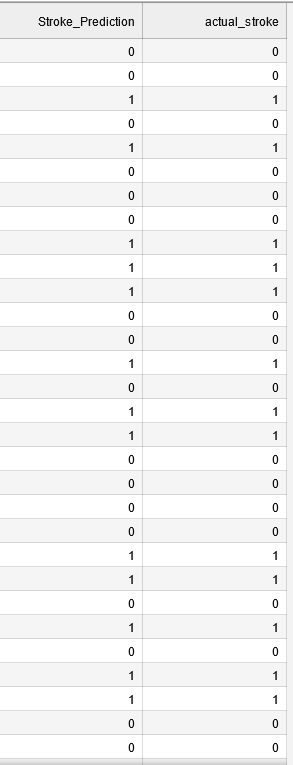

## **Thus predicted stroke and the actual value of 'stroke' in X_test closely match. This means our model performs well in batch prediction and it is ready to be put in production** 

In [ ]:
pip freeze>> requirements.txt